# 4. Optimización de Modelos

En el notebook anterior experimentamos con muchos modelos pre-entrenados y _transfer learning_.

Aplicamos un mecanismo conocido como **revisión** (o, en inglés, **spot-checking**), consistente en probar muchos algoritmos candidatos para determinar cuáles deben ser tomados en cuenta para mayores optimizaciones.

Al final, decidimos mantener los siguientes tres modelos:

 - **VGG16**. Número de parámetros: 15,108,929. Exactitud en el conjunto de validación: 99.32%.
 - **MobileNet**. Número de parámetros: 3,885,249.Exactitud en el conjunto de validación: 98.22%.
 - **NASNetMobile**. Número de parámetros: 4,942,485. Exactitud en el conjunto de validación: 97.27%.
 
El criterio detrás de esta decisión es que preferimos modelos más sencillas y pequeños que muestren un desempeño decente, en vez de una red gigantesca que sólo reporte una mejora diminuta en el rendimiento.

## ¿Cómo optimizar?

Aunque nuestros tres candidatos lo hacen decentemente en el conjunto de validación, seguramente podemos extraerle un poco más de exactitud. Con este fin en mente, experimentaremos con muchas, sino todas las técnicas siguientes:

 - __Aumento de datos__: Al proveer más ejemplos y más variados, el modelo debería ser capaz de generalizar mejor.
 - __Entrenar durante más _epochs___: En el último notebook sólo entrenamos los modelos durante 5 _epochs_ para ver si eran candidatos dignos. En esta ocasión les daremos más tiempo.
 - __Parada temprana__: El riesgo asociado a entrenar modelos durante mucho tiempo es que tienen a sobreajustarse a los datos. Para prevenir esto, usamos una técnica conocida como "parada temprana", la cual para el entrenamiento si el modelo no ha mejorado durante un determinado número de _epochs_.

## Optimizando los modelos

Seguiremos un plan similar al del notebook anterior. Nos apoyaremos en la función `get_models` para obtener las arquitecturas que optimizaremos. 

Seguidamente, entrenaremos a cada candidato durante un número de _epochs_, sólo que esta vez añadiremos una serie de _callbacks_ útiles. Finalmente, graficaremos la curva de aprendizaje, tanto para el conjunto de entrenamiento como para el de validación.

### Arquitectura

Las arquitecturas que estamos usando esta vez son un tanto distintas a las del tercer notebook. Para activar las capas del perceptrón multicapa optamos por **leaky ReLU** en vez de la versión tradicional, de manera que al menos una proporción mínima del error sea propagada hacia las primeras capas en la red. El problema con ReLU es que si, por algún motivo, produce una salida igual a cero, una porción considerable de la red podría morir y, en efecto, nunca más aprender. Con leaky ReLU esto no debería pasar.

También usamos **normalización por lotes**, la cual acelera el entrenamiento y también, como efecto colateral, regulariza a la red.

In [1]:
from tensorflow.keras import applications
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import gc

def get_models(models=None):
    # Takes a base, pretrained model, and attaches a new FCN on top of it.
    def get_model_with_new_top(base_model):
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dense(256)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        predictions = Dense(1, activation='sigmoid')(x)
        
        model = Model(inputs=base_model.input, outputs=predictions)
        
        for layer in base_model.layers:
            layer.trainable = False
            
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
        
        return model
        
    if models is None:
        models = dict()
        
    models['mobilenet'] = {
        'preprocessing_function': applications.mobilenet.preprocess_input,
        'model_constructor': lambda: get_model_with_new_top(applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
        'input_shape': (224, 224)
    }
    
    models['nasnet_mobile'] = {
        'preprocessing_function': applications.nasnet.preprocess_input,
        'model_constructor': lambda: get_model_with_new_top(applications.NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
        'input_shape': (224, 224)
    }
    
    models['vgg16'] = {
        'preprocessing_function': applications.vgg16.preprocess_input, 
        'model_constructor': lambda: get_model_with_new_top(applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))), 
        'input_shape': (224, 224)
    }
    
    return models

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Entrenamiento y Evaluación

Entrenaremos y validaremos el modelo usando el método `flow_from_directory()` en Keras.

Esta vez, aplicaremos los siguientes _callbacks_:

 - **EarlyStopping**: Detendremos el entrenamiento si después de 3 iteraciones el modelo no muestra mejoras en la mérica `val_acc`.
 - **ModelCheckpoint**: Al finalizar cada _epoch_, guardaremos una versión del modelo.
 - **ReduceLROnPlateau**: Si el aprendizaje de la red se estanca pasadas 3 _epochs_, reduciremos el _learning rate_.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

def train_and_evaluate_models(models, epochs=5, tta_steps=10):
    for model_name, model_data in models.items():
        m = model_data['model_constructor']()
        train_data_generator = ImageDataGenerator(preprocessing_function=model_data['preprocessing_function'],
                                                  horizontal_flip=True)
        
        generator = train_data_generator.flow_from_directory('./dataset/train', 
                                                             target_size=model_data['input_shape'],
                                                             batch_size=32,
                                                             class_mode='binary')

        callbacks = [
            EarlyStopping(patience=3),
            ModelCheckpoint(model_name + '.weights.{epoch:02d}-{val_acc:.4f}.hdf5', monitor='val_acc'),
            ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, min_lr=0.001)
        ]
        
        valid_data_generator = ImageDataGenerator(preprocessing_function=model_data['preprocessing_function']).flow_from_directory('./dataset/valid', 
                                                                                                                                   target_size=model_data['input_shape'],
                                                                                                                                   batch_size=32,
                                                                                                                                   class_mode='binary')
        print(f'Training {model_name}')
        history = m.fit_generator(generator=generator,
                                  callbacks=callbacks,
                                  validation_data=valid_data_generator,
                                  epochs=epochs)

        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


        del m
        del history
        K.clear_session()
        gc.collect()


Estamos listos para entrenar a los candidatos. ¿Qué tal lo harán?

Instructions for updating:
Colocations handled automatically by placer.
Found 6593 images belonging to 2 classes.
Found 732 images belonging to 2 classes.
Training mobilenet
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
207/207 [==============================] - 29s 139ms/step - loss: 0.0648 - acc: 0.9766 - val_loss: 0.0646 - val_acc: 0.9699
Epoch 2/15
207/207 [==============================] - 24s 118ms/step - loss: 0.0332 - acc: 0.9895 - val_loss: 0.0877 - val_acc: 0.9727
Epoch 3/15
207/207 [==============================] - 24s 117ms/step - loss: 0.0325 - acc: 0.9897 - val_loss: 0.0683 - val_acc: 0.9768
Epoch 4/15
207/207 [==============================] - 24s 117ms/step - loss: 0.0325 - acc: 0.9892 - val_loss: 0.0598 - val_acc: 0.9795
Epoch 5/15
207/207 [==============================] - 24s 117ms/step - loss: 0.0223 - acc: 0.9924 - val_loss: 0.0401 - val_acc: 0.9863
Epoch 6/15
207/207 [==============================] - 24s 116ms/step - loss: 0.0233 - acc: 0.9923 - val

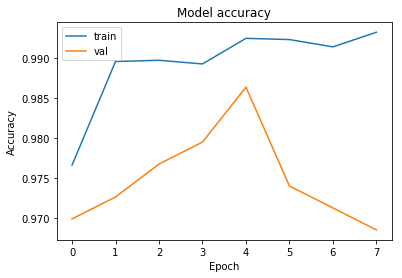

Found 6593 images belonging to 2 classes.
Found 732 images belonging to 2 classes.
Training nasnet_mobile
Epoch 1/15
207/207 [==============================] - 134s 645ms/step - loss: 0.1197 - acc: 0.9539 - val_loss: 0.2327 - val_acc: 0.9208
Epoch 2/15
207/207 [==============================] - 55s 266ms/step - loss: 0.0733 - acc: 0.9742 - val_loss: 0.1792 - val_acc: 0.9385
Epoch 3/15
207/207 [==============================] - 55s 265ms/step - loss: 0.0688 - acc: 0.9754 - val_loss: 0.1954 - val_acc: 0.9385
Epoch 4/15
207/207 [==============================] - 55s 264ms/step - loss: 0.0578 - acc: 0.9782 - val_loss: 0.2124 - val_acc: 0.9331
Epoch 5/15
207/207 [==============================] - 54s 259ms/step - loss: 0.0569 - acc: 0.9794 - val_loss: 0.1729 - val_acc: 0.9440
Epoch 6/15
207/207 [==============================] - 54s 262ms/step - loss: 0.0546 - acc: 0.9816 - val_loss: 0.0952 - val_acc: 0.9672
Epoch 7/15
207/207 [==============================] - 55s 264ms/step - loss: 0.0507

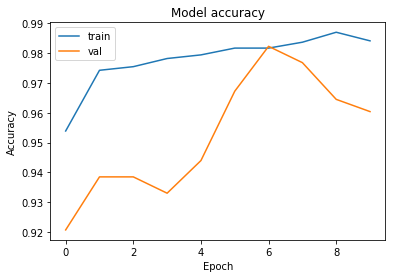

Found 6593 images belonging to 2 classes.
Found 732 images belonging to 2 classes.
Training vgg16
Epoch 1/15
207/207 [==============================] - 96s 462ms/step - loss: 0.0645 - acc: 0.9753 - val_loss: 0.0208 - val_acc: 0.9904
Epoch 2/15
207/207 [==============================] - 88s 426ms/step - loss: 0.0397 - acc: 0.9859 - val_loss: 0.0248 - val_acc: 0.9904
Epoch 3/15
207/207 [==============================] - 88s 427ms/step - loss: 0.0275 - acc: 0.9924 - val_loss: 0.0163 - val_acc: 0.9932
Epoch 4/15
207/207 [==============================] - 88s 425ms/step - loss: 0.0249 - acc: 0.9921 - val_loss: 0.0122 - val_acc: 0.9959
Epoch 5/15
207/207 [==============================] - 88s 425ms/step - loss: 0.0261 - acc: 0.9920 - val_loss: 0.0303 - val_acc: 0.9877
Epoch 6/15
207/207 [==============================] - 88s 426ms/step - loss: 0.0250 - acc: 0.9930 - val_loss: 0.0128 - val_acc: 0.9945
Epoch 7/15
207/207 [==============================] - 88s 426ms/step - loss: 0.0227 - acc: 0

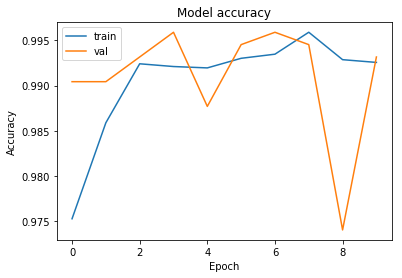

In [3]:
models = get_models()

EPOCHS = 15
TTA_STEPS = 10
train_and_evaluate_models(models, EPOCHS, TTA_STEPS)

## Conclusión

Estos son nuestros resultados:

 - **VGG16**. Alcanza su mejor exactitud en el conjunto de validación en el _epoch_ 4, la cual es 99.59%, un poco mejor que la obtenida en la revisión (99.32%).
 - **MobileNet**. Alcanza su mejor exactitud en el conjunto de validación en el _epoch_ 5, la cual es 98.63%, un poco mejor que la obtenida en la revisión (98.22%).
 - **NASNetMobile**. Alcanza su mejor exactitud en el conjunto de validación en el _epoch_ 7, la cual es 98.22% un poco mejor que la obtenida en la revisión (97.27%).
 
Podemos observar que, aunque sólo aumentamos nuestro conjunto de datos con el relejo de las imágenes originales (es decir, rotaciones horizontales alrededor del eje vertical) y entrenamos por unas cuantas iteraciones más, logramos obtener mejores resultados en todos los casos. Claro está, puede que la mejora no sea sustancial, ya que empezamos con buenos números, lo cual tiene que ver con el hecho de los datos no varían demasiado, lo que facilita considerablemente el trabajo de las redes.

Es interesante resaltar que después de optimizar las redes, VGG16 sigue siendo la que mejor se desempeña, pero la que se benefició mayormente de este proceso es NASNetMobile, con un incremento de 0.98% en la exactitud sobre el conjunto de validación.

## Ideas

Aquí están algunas ideas o extensiones que podrían ejecutarse en el futuro:

- Usar más imágenes.
- Usar aumento de datos en las pruebas (Test Time Augmentation).
- Usar _learning rate_ cíclico.
- Usar más técnicas de aumento de datos.
- Descongelar (entrenar) capas en los redes pre-entrenadas.